# Unsupervised learning: Clustering & DimRed

**Кластеризация** - задача разбиения объектов на группы (кластеры). Кластеризация не использует правильные ответы при обучении(разметку), поэтому это задача *обучения без учителя*.<br>

**Задача кластеризации** -- разбить пространство объектов на группы таким образом, чтобы одинаковые объекты были в одной группе, а разные  -- в разных группах<br>

Все алгоритмы кластеризации так или иначе **вычисляют близость между объектами** (это может быть, например, косинусное расстояние) и стараются организовать кластеры так, чтобы между объектами одного кластера было небольшое расстояние.

**Популярные методы кластеризации:**
- Kmeans
- Mean-Shift Clustering
- DBSCAN
- EM (Expectation–Maximization), GMM (Gaussian Mixture Models)
- Agglomerative Hierarchical Clustering 


**Метрики для кластеризации:**
- Silhouette Score
- Rand Index
- Adjusted Rand Index
- Mutual Information
- Calinski-Harabasz Index
- Davies-Bouldin Index

Про метрики можно [почитать тут](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)



Данные могут распологаться в пространстве "странным" образом: без четких границ, например, или иметь "выбросы".

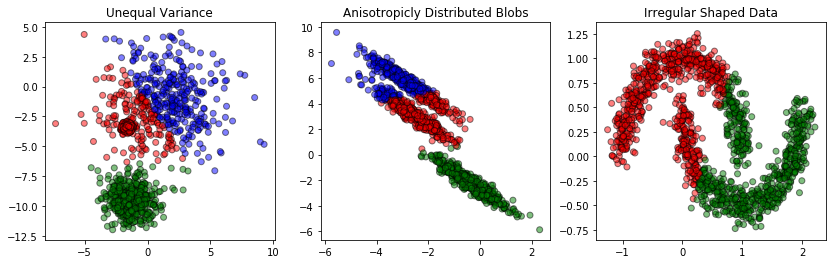
Так как считать близости между всеми объектами может быть долго, в конкретных алгоритмах кластеризации используются разные трюки (их мы рассмотрим в практической части).

# Практика - основная часть

У нас есть [датасет вин](https://www.kaggle.com/harrywang/wine-dataset-for-clustering), давайте попробуем их кластеризовать

In [ ]:
# imports here
import pandas as pd
import numpy as np

#viz
import seaborn as sns
import matplotlib.pyplot as plt

# progress bar
from tqdm import tqdm

Открываем датасет и посмотрим на него

In [ ]:
data = pd.read_csv('wine-clustering.csv')

In [ ]:
print(data.shape)
data.head(5)

Параметры в датасете:
- 

In [ ]:
data.info()

In [ ]:
data.describe()

## Проверим распределения параметров в датасете 
* если данные распределены нормально, сдвига не будет 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg/446px-Negative_and_positive_skew_diagrams_%28English%29.svg.png">

In [ ]:
data.skew() # можно посмотреть вот так сразу все столбцы

А можно сделать гистограммы для значений каждого столбца отдельно (каждый столбец = параметр в нашей будущей модели). Таким образом увидим распределение каждого и параметров. Это может быть полезно, так как:
* мы увидим распределение каждого параметра отдельно (выявим сдвиги, если они есть)
* определим выбросы

In [ ]:
sns.set(font_scale=1.5, rc={'figure.figsize':(15,15)})

ax=data.hist(color='blue' )


# обратите внимание на начения x и y 

Проверим, есть ли у параметров нулевые значения:

In [ ]:
data.isnull().any().any()

## Подготовка данных 

В качестве основного алгоритма мы будем использовать K-means. Так как он использует дистанцию как основную метрику для определения данных в кластеры, давайте нормируем значения параметров, чтобы они определялись на едином промежутке

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
data_scaled=data.copy()
data_scaled[data_scaled.columns]=std_scaler.fit_transform(data_scaled)

In [ ]:
data_scaled.head(3)

In [ ]:
# отрисуем распределения параметров еще раз: формы не изменились, а шкалы изменились (стали едиными для всех параметров) 

sns.set(font_scale=1, rc={'figure.figsize':(15,15)})

ax=data_scaled.hist(color='blue')

In [ ]:
display(data_scaled.min())
# data_scaled.max().max()

A еще можем нарисовать тепловую карту корреляций параметров:

In [ ]:
corr = data_scaled.corr()

plt.figure(figsize=(12,10))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True)

**Мы имеем дело с многомерным датасетом:** каждый параметр обраует свое измерение, всего у нас 13-мерное пространство! Кластеры в таком пространстве эффективно собрать не получится, давайте уменьшим пространство: найдем две компоненты, вдоль которых существует наибольшая дисперсия данных. Такой метод называется методом главных компонент или PCA [Principle Component Analysis] (объяснение [полегче](https://habr.com/ru/post/304214/) и [посложнее](http://machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82))

In [ ]:
from sklearn.decomposition import PCA
pca_2 = PCA(2) # задали количество компонент

pca_2_result = pca_2.fit_transform(data_scaled) 

pca_2_result.shape # массив длиной в кол-во строк датасета и шириной по числу компонент

Давайте это визуализируем

In [ ]:
sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

## Кластеризация

[здесь можно почитать про основные алгоритмы](https://scikit-learn.org/stable/modules/clustering.html)

**K-means (метод k средних)**

- Cлучайным образом в пространстве данных определяем k точек,называем их центроидами. 
- Оставшиеся точки относим к ближайшему для них центроиду  — получаются как бы "скопления" точек с некоторым центром.
- Определяем центр каждого "скопления", передвигаем центроид туда
- Повторяем предыдущий шаг, пока центроиды не перестанут двигаться.
- Готово. Кластеры обнаружены и стабильны

<img alt="" class="xb xw ep fd ez ku v c" width="480" height="480" role="presentation" src="https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif" srcset="https://miro.medium.com/max/552/1*KrcZK0xYgTa4qFrVr0fO2w.gif 276w, https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif 480w" sizes="480px">

[сорс](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)

**формула кластеризации** $\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$

**Плюсы:**
- относительно высокая скорость работы алгоритма <br>
(между $О(n^2)$ и $O(n)$, в среднем -- $О(nki)$ где $n$ - количество данных, $k$ - количество центров/кластеров, $i$ - число итераций алгоритма до устойчивости кластеров)

**Минусы**
- необходимо заранее знать, сколько кластеров понадобится (чему равно k)
- алгоритм недетерминированный, следовательно, реультаты могут именяться при каждом запуске (тк центроиды выбираются рандомно)

<img src="https://static-content.springer.com/image/prt%3A978-0-387-30164-8%2F12/MediaObjects/978-0-387-30164-8_12_Part_Fig2-425_HTML.jpg" alt="">

[сорс](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-30164-8_425)

Есть похожий алгоритм -- **K-Medians** -- при пересчитывании центра "скопления" точек, он использует не среднее, а медианное значения вектора группы точек.<br>
**Плюсы метода:** бóльшая устройчивость к статистическим выбросам (outliers)

**Минусы:** алгоритм более медленный, так как определение медианы на каждой итерации предполагает дополнительную сортировку данных

### Как определить число кластеров?

Такой вопрос часто задают на собеседованиях. Сделаем это с помощью двух методов: Silhouette Score и Elbow analysis

Сначала посчитаем *инерцию* (это тоже метрика, она считается как сумма квадратов ошибок для каждого кластера). Чем ниже значения инерции, тем более "плотные" получились кластеры, следовательно, тем лучше прошла кластеризация 

In [ ]:
# https://scikit-learn.org/stable/modules/clustering.html#k-means

import sklearn.cluster as cluster

inertia = [] # сюда будем сохранять значения
for i in tqdm(range(2,10)): # значения интервала - число кластеров (можно изменять) 
    kmeans = cluster.KMeans( n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17) # сколько раз датасет перемешан перед кластеризацией
    
    
    kmeans.fit(pca_2_result) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров
    
print(inertia)

Следующая метрика -- силуэты. Чем больше значение, тем лучше прошла кластеризация

Силуэты считаются как отношение среднего внутри кластера $a$ и среднего к ближайшему кластеру $b$ для каждой точки. $Silhouette Coefficient = (b - a) / max(a, b)$

In [ ]:
from sklearn.metrics import silhouette_score

# все как в предыдущей ячейке, только силуэт-скоры сохраняем как значения в словаре
silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(data_scaled)
    
    silhouette[i] = silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean')

print(silhouette)

Давайте это визуализируем:

In [ ]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue') 
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

**k=3 - самое подходящее значение для количества кластеров на наших данных** (k=4 чуть хуже, но можно и его попробовать потом)

In [ ]:
kmeans = cluster.KMeans(n_clusters=3,random_state=17,init='k-means++')

kmeans_labels = kmeans.fit_predict(pca_2_result)
# вычисляем центры кластеров и предугадываем номер кластера для каждого семпла данных

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts()) # кол-во вин по кластерам
kmeans_labels

In [ ]:
#  добавим информацию о кластерах в датафрейм
data_scaled['Cluster']=kmeans_labels

data_scaled

## PCA Clusters Visualization

In [ ]:
sns.set( rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# добавить легенду

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

Осталось посчитать метрики:

In [ ]:
# силуэты: определяется на промежутке [-1;1] (чем выше тем лучше)

# инерция: определяется от 0 и выше (чем ниже тем лучше)

print("Inertia score: %0.1f" % kmeans.inertia_,
     "\nSilhouette score: %0.1f" % silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean'))

Границы кластеров довольно четкие, но сами кластеры "рыхлые"

# дополнительные алгоритмы кластеризации

#### Импотируем разные алгоритмы кластеризации и метрики 

In [ ]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN,\
                            MeanShift, SpectralClustering

from sklearn import metrics

from sklearn.datasets import make_blobs

## AffinityPropagation

<img alt="8. Illustration of how affinity propagation works. Taken from [42]. |  Download Scientific Diagram" class="n3VNCb" src="https://www.researchgate.net/profile/Ferran-Torrent-Fontbona/publication/265969600/figure/fig8/AS:295818004320262@1447539916523/Illustration-of-how-affinity-propagation-works-Taken-from-42.png" data-noaft="1" jsname="HiaYvf" jsaction="load:XAeZkd;" style="width: 800px; height: 500px; margin: 0px;">

В AP специальным образом ([попарно](https://scikit-learn.org/stable/modules/clustering.html)) ищутся "экземпляры", объекты в выборке которые могут использоваться как центроиды. Ближайшие к ним объекты записываются в этот кластер.

**Приемущества AP** - не нужно подбирать количество кластеров.  
**Недостатки** - медленный *(не очень хорошо работает с дасетами 10к+ строчек)* и тратится много памяти, параметры не очевидные.

У AP два основных параметра - damping (чувствительность к обновлениям, можно рассматривать как learning rate, существует на промежутке [0.5; 1]) и preference(количество находимых экземпляров, чем выше значение, тем больше кластеров).

(Ещё можно поставить max_iter побольше 200, если обучение не сошлось)

[а вот вся документация к AP](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation)

In [ ]:
X = data_scaled.drop("Cluster",axis=1) # матрица признаков и их весов

cluster = AffinityPropagation(damping=0.7, preference=-5, 
                              max_iter=400, random_state= 42)
cluster.fit(X)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [ ]:
labels = cluster.labels_
labels

Посмотрим сколько кластеров образовалось

In [ ]:
len(set(labels))

Давайте попробуем посчитать метрики 

In [ ]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

Если помимо предсказанных лейблов (у нас они в переменной ```labels```) есть размеченные лейблы (```y```), можно использовать эти метрики:

(обычно их нет, поэтому это и обучение без учителя)

In [ ]:
# эти три метрки что-то вроде точности, полноты и F-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
# проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) 
# проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
# превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Сложно сказать, насколько хорошие или плохие это числа. Давайте попробуем посмотреть глазами

In [ ]:
data_scaled['Cluster'] = cluster.labels_

In [ ]:
data_scaled.groupby(['Cluster']).mean() # перегруппировали датасет, теперь индексы - это кластеры

## AgglomerativeClustering

<img alt="" class="xb xw ep fd ez ku v c" width="720" height="324" role="presentation" src="https://miro.medium.com/max/1440/1*ET8kCcPpr893vNZFs8j4xg.gif" srcset="https://miro.medium.com/max/552/1*ET8kCcPpr893vNZFs8j4xg.gif 276w, https://miro.medium.com/max/1104/1*ET8kCcPpr893vNZFs8j4xg.gif 552w, https://miro.medium.com/max/1280/1*ET8kCcPpr893vNZFs8j4xg.gif 640w, https://miro.medium.com/max/1400/1*ET8kCcPpr893vNZFs8j4xg.gif 700w" sizes="700px">

В агломеративной кластеризации каждому объекту припывается свой кластер и потом ближайшие кластеры постепенно объединяются, пока не получится общим супер-кластер. 

Когда рассказывают про этот вид кластеризации обычно рисуют вот такие картинки (дендрограммы). Предполагается, что можно посмотреть на то, как объекты постепенно соединяются и найти оптимальное количество кластеров. Однако это сработает только на небольшом количестве объектов, больше 100 объектов нарисовать будет сложно.

**Плюсы:** этот вид кластеризации может обработать большое количество данных <br>
**Минусы:** неудобная визуализация большого количества объектов
 

In [ ]:
# так как визуально мы не может найти оптимальное количество кластеров, придется подбирать

X = data_scaled.drop("Cluster",axis=1) # матрица признаков и их весов
cluster = AgglomerativeClustering(n_clusters=3)
cluster.fit(X)

In [ ]:
data_scaled['Cluster'] = cluster.labels_
data_scaled.groupby(['Cluster']).mean()

Давайте попробуем посчитать метрики 

In [ ]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, cluster.labels_))

## Mean Shift

<img alt="" class="xb xw ep fd ez ku v c" width="324" height="324" role="presentation" src="https://miro.medium.com/max/648/1*bkFlVrrm4HACGfUzeBnErw.gif" srcset="https://miro.medium.com/max/552/1*bkFlVrrm4HACGfUzeBnErw.gif 276w, https://miro.medium.com/max/648/1*bkFlVrrm4HACGfUzeBnErw.gif 324w" sizes="324px">

MS ищет плотные скопления объектов и ставит там кружочки определеного размера. Все, что попадает в кружочек, относится к кластеру. Количество кластеров задавать не нужно. 

Это первый из рассмотренных алгоритмов, который не относит к кластерам все объекты.

In [ ]:
# bandwidth - как раз рамер этого кружка, но его сложно подбирать самому, т.к. в каждой задаче он будет свой
# вот так можно узнать, что будет по умолчанию и начать с этого значения, постепенно уменьшая или увеличивая
import sklearn

sklearn.cluster.estimate_bandwidth(X)

In [ ]:
# cluster_all=False чтобы не записывать все объекты в кластеры
X = data_scaled.drop("Cluster",axis=1)
cluster = MeanShift(cluster_all=False, bandwidth=3.5)
cluster.fit(X)

Посмотрим сколько кластеров образовалось

In [ ]:
len(set(cluster.labels_))

In [ ]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, cluster.labels_))

In [ ]:
data_scaled['Cluster'] = cluster.labels_
# data_scaled.groupby(['Cluster']).mean()

Алгоритмы кластеризация, которые умеют отфильтровывать выбросы, приписывают им -1 кластер.

In [ ]:
# так мы можем оценить, действительно ли отсеивается мусор или мы просто недокластеризуем
data_scaled[data_scaled['Cluster']==-1].head()

## Spectral Clustering

В SC перед тем как кластерозовать к объектам применяется преобразование. Это преобразование должно приводить "странно" организованные в пространстве объекты к более стандартному виду, который могут переварить простые алгоритмы кластеризации (по дефолту используется KMEANS)

Так как кластируется через kmeans нужно подбирать количество кластеров самому.

In [ ]:
X = data_scaled.drop("Cluster",axis=1)
cluster = SpectralClustering(n_clusters=3)
cluster.fit(X)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [ ]:
cluster.labels_

Давайте попробуем посчитать метрики 

In [ ]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, cluster.labels_))

In [ ]:
data_scaled['Cluster'] = cluster.labels_
data_scaled.groupby(['Cluster']).mean()

## DBSCAN

<img alt="" width="675" height="424" src="https://miro.medium.com/max/1350/1*tc8UF-h0nQqUfLC8-0uInQ.gif">

DBSCAN похож на MS и Spectral Clustering. К данным применяется некоторое преобразование, чтобы определить близкие объекты и ещё дальше откинуть выбросы. Потом выбирается какой-то объект, и в его окрестностях ищутся другие объекты. Если находятся, то эти объекты сливаются в один кластер и так далее до устойчивости. Если количество объектов в кластере меньше порога, то объекты считаются выбросами.

DBSCAN сам находит количество кластеров и умеет отфильтровывать выбросы. Параметрами можно настраивать объём окрестности и таким образом влиять на кластеры.

[Интерактивная визуализация](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

In [ ]:
# eps - задает максимальную для объединения дистанцию между объектами == размер окрестности
# min_samples - минимальное количество объектов в классе

X = data_scaled.drop("Cluster",axis=1)
cluster = DBSCAN(min_samples=2, eps=0.5) 
cluster.fit(X)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [ ]:
cluster.labels_

Посмотрим сколько кластеров образовалось

In [ ]:
len(set(cluster.labels_))

In [ ]:
data_scaled['Cluster'] = cluster.labels_
data_scaled.groupby(['Cluster']).mean()

Давайте попробуем посчитать метрики 

In [ ]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X,cluster.labels_ ))

Есть еще HDBSCAN - оптимизированная версия DBSCAN. Его нет в sklearn, но есть [отдельная библиотека с аналогичным интерфейсом](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html )